In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [255]:
# files to read => chb01_03.edf, chb01_04.edf, chb01_15.edf,  chb01_16.edf,  chb01_18.edf,  chb01_21.edf,  chb01_26.edf,  chb02_16.edf, chb02_19.edf, chb03_01.edf, chb03_02.edf, chb03_03.edf, chb03_04.edf
files_to_read = [
        'chb01_03.edf',
        'chb01_04.edf',
        'chb01_15.edf',
        'chb01_16.edf',
        'chb01_18.edf',
        'chb01_21.edf',
        'chb01_26.edf',
        'chb02_16.edf',
        'chb02_19.edf',
        'chb03_01.edf',
        'chb03_02.edf',
        'chb03_03.edf',
        'chb03_04.edf',
        'chb04_05.edf',
        'chb04_28.edf',
        'chb05_06.edf',
        'chb05_13.edf',
        'chb05_16.edf',
        'chb05_17.edf',
        'chb05_22.edf',
        'chb06_04.edf',
        'chb06_09.edf',
        'chb06_10.edf',
        'chb06_13.edf',
        'chb06_18.edf',
        'chb06_24.edf',
        'chb07_12.edf',
        'chb07_13.edf',
        'chb07_19.edf',
        'chb08_02.edf',
        'chb08_05.edf',
        'chb08_11.edf',
        'chb08_13.edf',
        'chb08_21.edf',
        'chb09_06.edf',
        'chb09_08.edf',
        'chb09_19.edf',
        'chb10_12.edf',
        'chb10_20.edf',
        'chb10_27.edf',
        'chb10_30.edf',
        'chb10_31.edf',
        'chb10_38.edf',
        'chb10_89.edf',
        ]
seizure_seconds_each_file_start_and_end_seconds = [
        ('chb01_03.edf',2996, 3036),
        ('chb01_04.edf', 1467, 1494),
        ('chb01_15.edf', 1732, 1772),
        ('chb01_16.edf',1015, 1066),
        ('chb01_18.edf', 1720, 1810),
        ('chb01_21.edf', 327, 420),
        ('chb01_26.edf', 1862, 1963),
        ('chb02_16.edf', 130, 212),
        ('chb02_19.edf', 2972, 3053),
        ('chb03_01.edf', 362, 414),
        ('chb03_02.edf', 731, 796),
        ('chb03_03.edf', 432, 501),
        ('chb03_04.edf', 2162, 2214),
        ('chb04_05.edf', 7804, 7853),
        ('chb04_28.edf', 1679, 1781),
        ('chb05_06.edf', 417, 532),
        ('chb05_13.edf', 1086, 1196),
        ('chb05_16.edf', 2317, 2413),
        ('chb05_17.edf', 2451, 2571),
        ('chb05_22.edf', 2348, 2465),
        ('chb06_04.edf', 327, 347),
        ('chb06_09.edf', 12500, 12516),
        ('chb06_10.edf', 10833, 10845),
        ('chb06_13.edf', 506, 519),
        ('chb06_18.edf', 7799, 7811),
        ('chb06_24.edf', 9387, 9403),
        ('chb07_12.edf', 4920, 5006),
        ('chb07_13.edf', 3285, 3381),
        ('chb07_19.edf', 13688, 13831),
        ('chb08_02.edf', 2670, 2841),
        ('chb08_05.edf', 2856, 3046),
        ('chb08_11.edf', 2988, 3122),
        ('chb08_13.edf', 2417, 2577),
        ('chb08_21.edf', 2083, 2347),
        ('chb09_06.edf', 12231, 12295),
        ('chb09_08.edf', 2951, 3030),
        ('chb09_19.edf', 5299, 5361),
        ('chb10_12.edf', 6313, 6348),
        ('chb10_20.edf', 6888, 6958),
        ('chb10_27.edf', 2382, 2447),
        ('chb10_30.edf', 3021, 3079),
        ('chb10_31.edf', 3801, 3877),
        ('chb10_38.edf', 4618, 4707),
        ('chb10_89.edf', 1383, 1437),
        ]
signals = []

for file in files_to_read:
        f = pyedflib.EdfReader(file)
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        fz_cz_index = signal_labels.index('FZ-CZ')
        cz_pz_index = signal_labels.index('CZ-PZ')
        sigbufs = np.zeros((2, f.getNSamples()[0]))
        sigbufs[0] = f.readSignal(fz_cz_index)
        sigbufs[1] = f.readSignal(cz_pz_index)
        signals.append(np.array(sigbufs))
        f.close()
print(len(signals), len(files_to_read), len(seizure_seconds_each_file_start_and_end_seconds))

44 44 44


In [256]:
signals[0].shape

(2, 921600)

In [262]:
shortened_signals = signals[0:18]

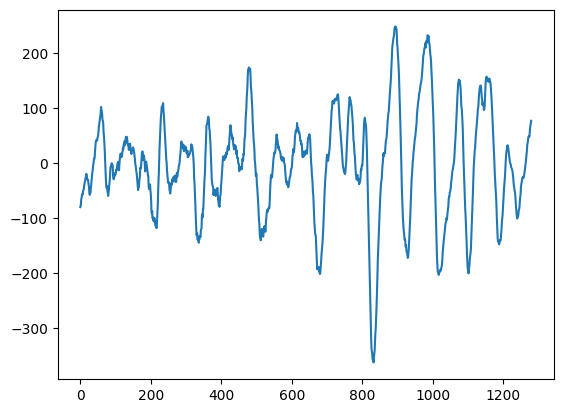

In [257]:
#plot the signal of first file from start seizure time to end seizure time
plt.plot(signals[1][0][1467*256:1472*256])

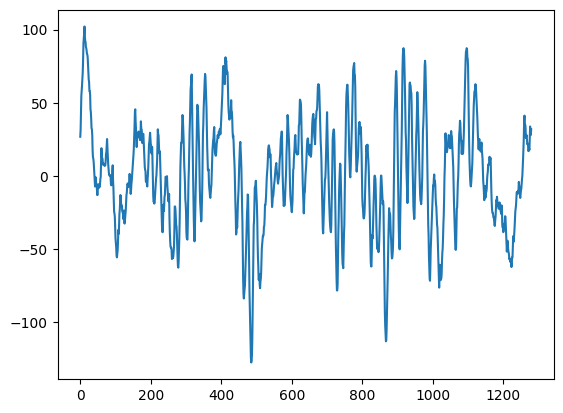

In [258]:
plt.plot(signals[1][0][500*256:505*256])

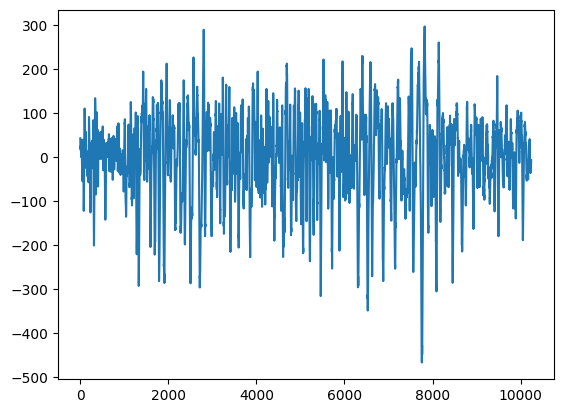

In [259]:
#plot the signal of first file from start seizure time to end seizure time
plt.plot(signals[0][0][2996*256:3036*256])

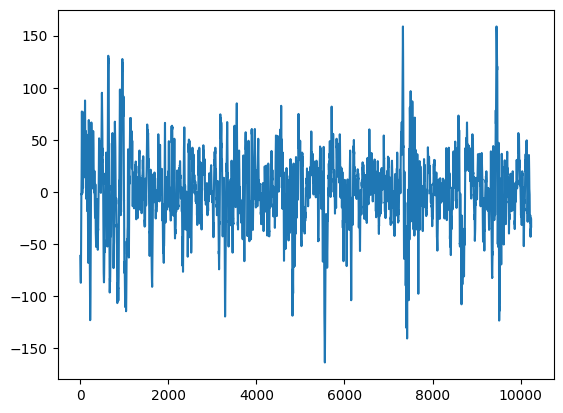

In [260]:
plt.plot(signals[0][0][2700*256:2740*256])

In [273]:
#loop only in seizure time

window_size = 5 * 256
seizure_data_signals = np.zeros((0, 2, window_size))
seizure_data_y_labels = []

for i in range(len(shortened_signals)):
    try:
        print(i)
        start_time = seizure_seconds_each_file_start_and_end_seconds[i][1]*256
        end_time = seizure_seconds_each_file_start_and_end_seconds[i][2]*256
        for j in range(start_time, end_time, 256*1):
            seizure_data_signals = np.append(seizure_data_signals, np.array([shortened_signals[i][:, j:j+window_size]]), axis=0)
            seizure_data_y_labels.append(1)
    except:
        print("error in file:")
        print(i)
        continue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


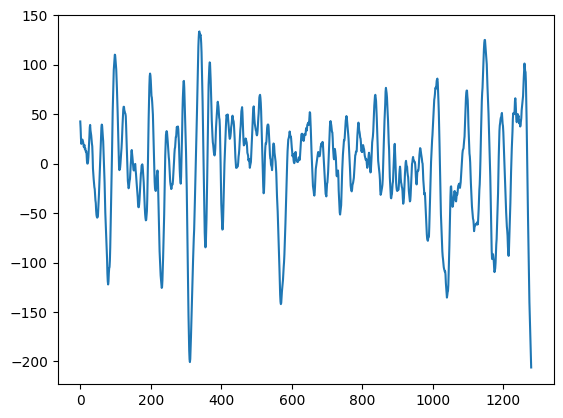

In [271]:
plt.plot(seizure_data_signals[0][0])

In [274]:
len(seizure_data_y_labels)

1315

In [279]:
#delete the first 5 percent and last 5 percent of the signal
import copy
new_signals = copy.deepcopy(shortened_signals)
for i in range(len(new_signals)):
    new_signals[i] = new_signals[i][:,int(0.05*len(new_signals[i][0])):int(0.95*len(new_signals[i][0]))]

In [280]:
#delete the seizure time from the signals
for i in range(len(new_signals)):
    try:
        start_time = seizure_seconds_each_file_start_and_end_seconds[i][1]*256
        end_time = seizure_seconds_each_file_start_and_end_seconds[i][2]*256
        new_signals[i] = np.delete(new_signals[i], np.s_[start_time:end_time], axis=1)
    except:
        print("error in file:")
        print(i)
        continue

In [281]:
print(new_signals[0].shape, shortened_signals[0].shape)

(2, 819200) (2, 921600)


In [283]:
#peek 5000 random samples from the signals
import random
non_seizure_data_signals = np.zeros((0, 2, window_size))
non_seizure_data_y_labels = []

for i in range(len(new_signals)):
    print(i)
    for j in range(80):
        random_index = random.randint(0, len(new_signals[i][0])-window_size)
        non_seizure_data_signals = np.append(non_seizure_data_signals, np.array([new_signals[i][:, random_index:random_index+window_size]]), axis=0)
        non_seizure_data_y_labels.append(0)

len(non_seizure_data_y_labels)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


1440

In [284]:
non_seizure_data_signals.shape

(1440, 2, 1280)

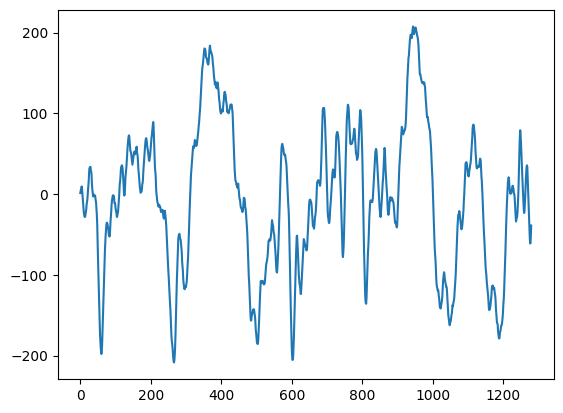

In [286]:
plt.plot(non_seizure_data_signals[0][0])

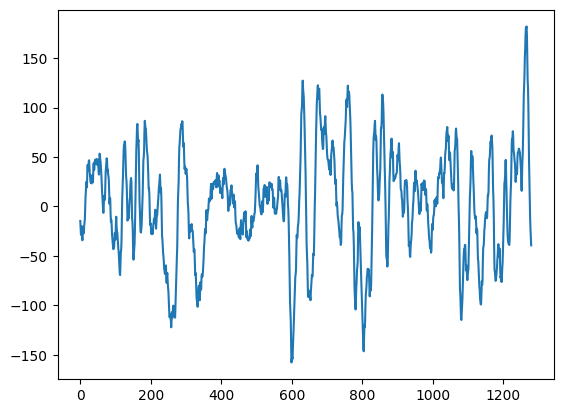

In [287]:
plt.plot(non_seizure_data_signals[450][0])

In [288]:
final_signals =np.zeros((0, 2, window_size))
final_y_labels = []

In [289]:
final_signals = np.append(seizure_data_signals, non_seizure_data_signals, axis=0)
final_y_labels = np.append(seizure_data_y_labels, non_seizure_data_y_labels, axis=0)

In [290]:
print(final_signals.shape, final_y_labels.shape)

(2755, 2, 1280) (2755,)


In [291]:
#data augmentation

#flip the signal
flipped_signals = np.flip(final_signals, axis=2)
flipped_y_labels = final_y_labels

#add noise
noise = np.random.normal(0, 0.1, final_signals.shape)
noisy_signals = final_signals + noise
noisy_y_labels = final_y_labels

#concatenate the original, flipped and noisy signals
augmented_signals = np.append(final_signals, flipped_signals, axis=0)
augmented_signals = np.append(augmented_signals, noisy_signals, axis=0)
augmented_y_labels = np.append(final_y_labels, flipped_y_labels, axis=0)
augmented_y_labels = np.append(augmented_y_labels, noisy_y_labels, axis=0)

print(augmented_signals.shape, augmented_y_labels.shape)

(8265, 2, 1280) (8265,)


In [292]:
sum(augmented_y_labels)

3945

In [201]:
#normalize the signals with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_signals = scaler.fit_transform(augmented_signals.reshape(-1, 2*window_size)).reshape(-1, 2, window_size)
final_signals.shape

(7977, 2, 5120)

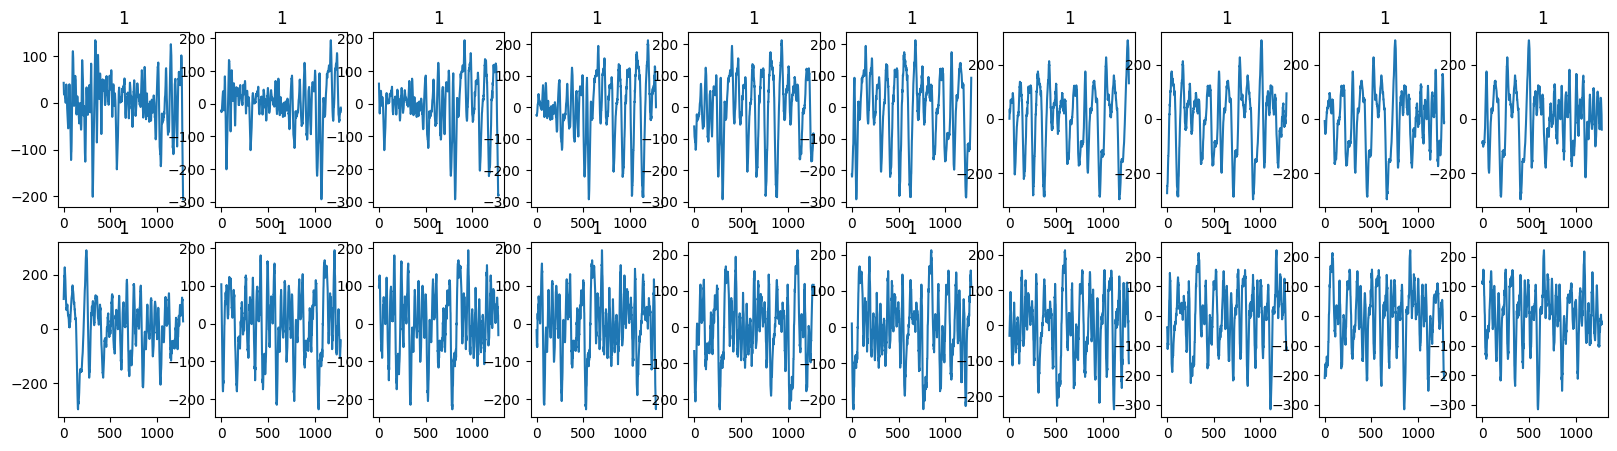

In [293]:
#plot 10 signals with label 1 and 10 signals with label 0 in a grid of small plots
fig, axs = plt.subplots(2, 10, figsize=(20, 5))
for i in range(10):
    axs[0, i].plot(final_signals[i][0])
    axs[0, i].set_title(augmented_y_labels[i])
    axs[1, i].plot(final_signals[i+10][0])
    axs[1, i].set_title(augmented_y_labels[i+10])

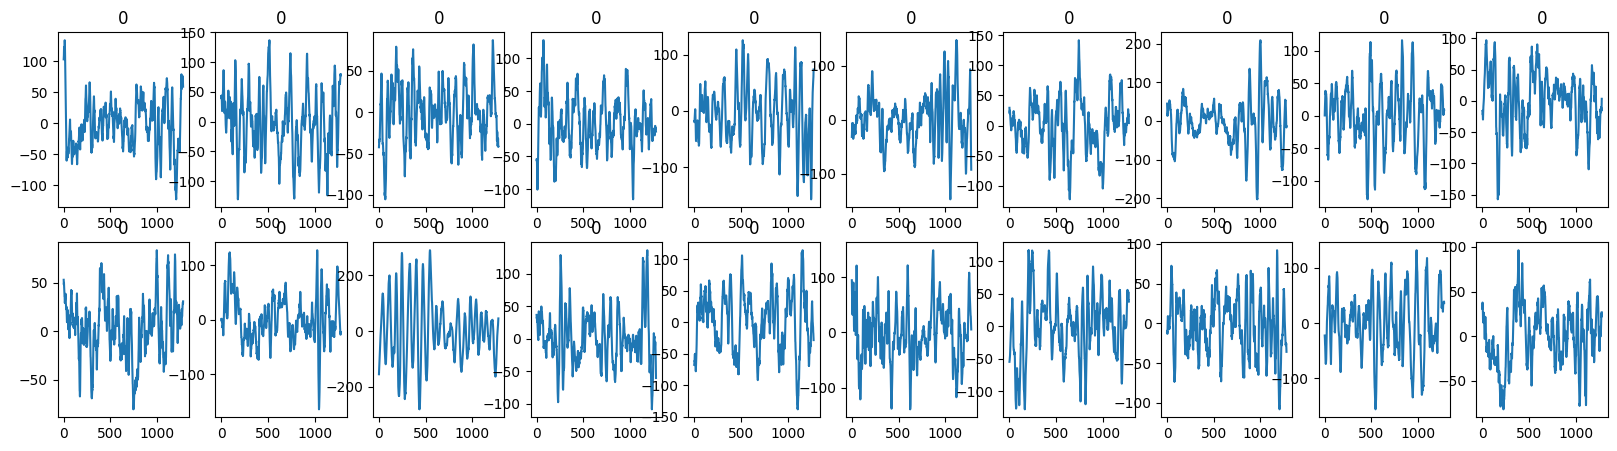

In [294]:
#plot 10 signals from last of the array
fig, axs = plt.subplots(2, 10, figsize=(20, 5))
for i in range(10):
    axs[0, i].plot(final_signals[-i-1][0])
    axs[0, i].set_title(augmented_y_labels[-i-1])
    axs[1, i].plot(final_signals[-i-11][0])
    axs[1, i].set_title(augmented_y_labels[-i-11])

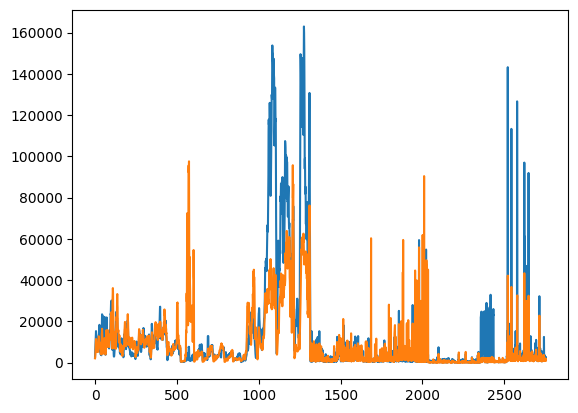

In [295]:
var = np.var(final_signals, axis=2)
plt.plot(var)

In [296]:
fft = np.fft.fft(final_signals, axis=2)
fft.shape

(2755, 2, 1280)

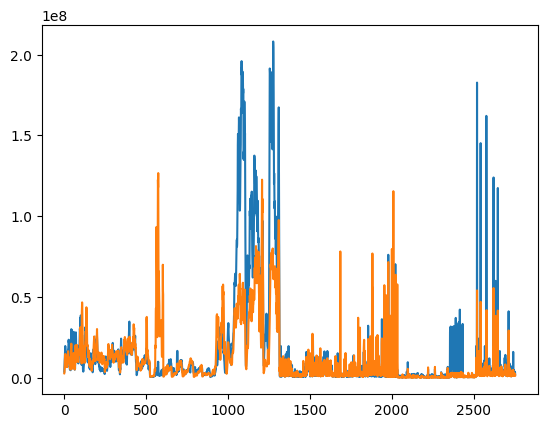

In [297]:
fft_var = np.var(fft, axis=2)
plt.plot(fft_var)

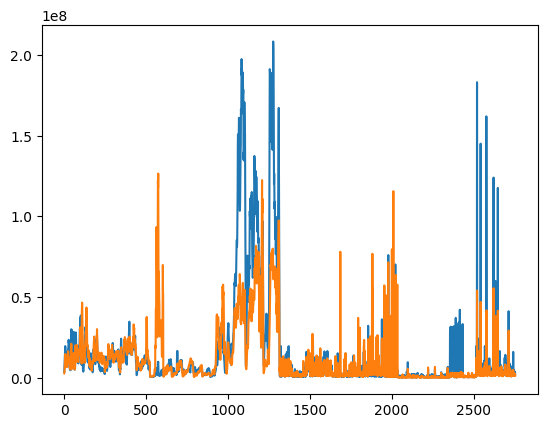

In [298]:
energy = np.sum(np.square(final_signals), axis=2)
plt.plot(energy)

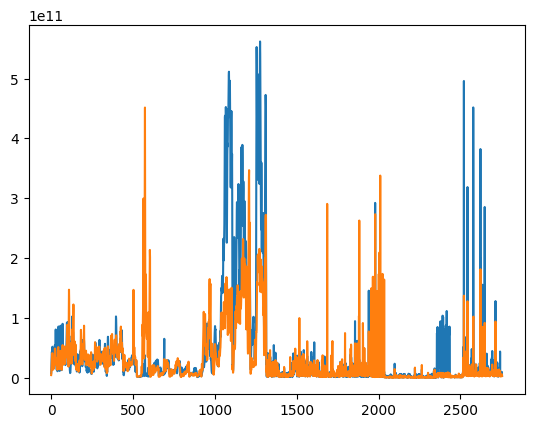

In [300]:
#complexity
complexity = np.sum(np.square(np.abs(np.diff(fft, axis=2))), axis=2)
plt.plot(complexity)

In [301]:
features = np.concatenate((var, fft_var, energy, complexity), axis=1)
features.shape

(2755, 8)

In [307]:
#random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 


#split the data to train and test

X_train, X_test, y_train, y_test = train_test_split(features, final_y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

confusion_matrix(y_test, y_pred)

0.8439201451905626


array([[244,  45],
       [ 41, 221]], dtype=int64)

In [308]:
#random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

#use just one channel of the signals
final_signals_one_channel = final_signals[:, 0, :]

#split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(final_signals_one_channel, final_y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
#confusion matrix
confusion_matrix(y_test, y_pred)

0.7531760435571688


array([[236,  53],
       [ 83, 179]], dtype=int64)

In [309]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(final_signals, final_y_labels, test_size=0.2, random_state=42)

In [310]:
X_train.shape

(2204, 2, 1280)

In [311]:
#one hot encode target column
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# big model

In [325]:
#now lets make the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=10, activation='relu', input_shape=(window_size, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
#add our features to the last fully connected layer
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 1271, 256)         5376      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 635, 256)         0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 635, 256)          0         
                                                                 
 conv1d_22 (Conv1D)          (None, 626, 128)          327808    
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 313, 128)         0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 313, 128)        

# small model

In [312]:
#now lets build a model our filters should get every 2 seconds of data
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(features.shape[1], activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 1279, 64)          320       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 639, 64)          0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 40896)             0         
                                                                 
 dense_14 (Dense)            (None, 8)                 327176    
                                                                 
 dense_15 (Dense)            (None, 2)                 18        
                                                                 
Total params: 327,514
Trainable params: 327,514
Non-trainable params: 0
________________________________________________

# model with features

In [ ]:
from keras.layers import Input, Concatenate
from keras.models import Model

# define inputs for each feature 
var_input = Input(shape=(5120,2)) 
fft_var_input = Input(shape=(5120,2)) 
energy_input = Input(shape=(5120,2)) 
complexity_input = Input(shape=(5120,2)) 
# define the model architecture 
x = Conv1D(filters=256, kernel_size=10, activation='relu', input_shape=(5120, 2))(var_input) 
x = MaxPooling1D(pool_size=2)(x) 
x = Dropout(0.3)(x) 
x = Conv1D(filters=128, kernel_size=10, activation='relu')(x) 
x = MaxPooling1D(pool_size=2)(x) 
x = Dropout(0.3)(x) 
x = Conv1D(filters=128, kernel_size=10, activation='relu')(x) 
x = MaxPooling1D(pool_size=2)(x) 
x = Dropout(0.3)(x)   # concatenate all features with the last fully connected layer   x = Concatenate()([fft_var_input, energy_input , complexity_input , x])   x = Dense(50, activation='relu')(x)   output = Dense(2, activation='softmax')(x)    # create and compile the model   model = Model([var_input , fft_var_input , energy_input , complexity], output )   model.compile('adam', 'categorical-crossentropy', metrics=['accuracy'])
x = Concatenate()([fft_var_input, energy_input , complexity_input , x])
x = Dense(50, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# create and compile the model
model_with_features = Model([var_input , fft_var_input , energy_input , complexity], output )
model_with_features.compile('adam', 'categorical-crossentropy', metrics=['accuracy'])
model_with_features.summary()

In [326]:
X_train = X_train.reshape(X_train.shape[0], window_size, 2)
X_test = X_test.reshape(X_test.shape[0], window_size, 2)

In [327]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train.shape

(2204, 1280, 2)

In [328]:
X_train.shape

(2204, 1280, 2)

In [329]:
model.fit(
    X_train,
    y_train_categorical,
    epochs=10,
    shuffle=True,
    verbose=2
)

Epoch 1/10
69/69 - 41s - loss: 1.8939 - accuracy: 0.5113 - 41s/epoch - 592ms/step
Epoch 2/10
69/69 - 44s - loss: 0.6207 - accuracy: 0.5848 - 44s/epoch - 637ms/step
Epoch 3/10
69/69 - 50s - loss: 0.5932 - accuracy: 0.6583 - 50s/epoch - 719ms/step
Epoch 4/10
69/69 - 42s - loss: 0.5655 - accuracy: 0.7169 - 42s/epoch - 611ms/step
Epoch 5/10
69/69 - 40s - loss: 0.5498 - accuracy: 0.7623 - 40s/epoch - 575ms/step
Epoch 6/10
69/69 - 40s - loss: 0.5253 - accuracy: 0.7731 - 40s/epoch - 577ms/step
Epoch 7/10
69/69 - 40s - loss: 0.5087 - accuracy: 0.7877 - 40s/epoch - 577ms/step
Epoch 8/10
69/69 - 42s - loss: 0.4756 - accuracy: 0.8108 - 42s/epoch - 609ms/step
Epoch 9/10
69/69 - 43s - loss: 0.4526 - accuracy: 0.8217 - 43s/epoch - 627ms/step
Epoch 10/10
69/69 - 40s - loss: 0.4131 - accuracy: 0.8457 - 40s/epoch - 582ms/step


In [330]:
#evaluate the model
model_loss, model_accuracy = model.evaluate(
    X_test, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

18/18 - 3s - loss: 0.4673 - accuracy: 0.8131 - 3s/epoch - 155ms/step
Normal Neural Network - Loss: 0.4672781825065613, Accuracy: 0.8130671381950378


In [331]:
#model recall and f1 score and precision
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_pred))

18/18 [==============================] - 3s 135ms/step
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       289
           1       0.75      0.92      0.82       262

    accuracy                           0.81       551
   macro avg       0.83      0.82      0.81       551
weighted avg       0.83      0.81      0.81       551



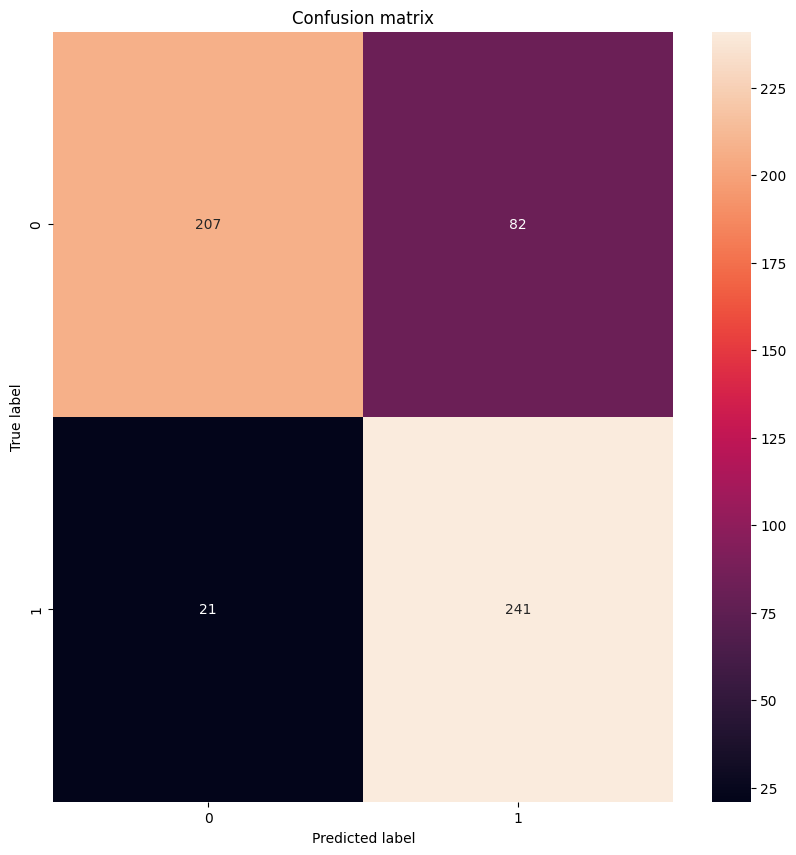

In [332]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [333]:
#false alarm rate
false_alarm_rate = cm[0][1]/(cm[0][1]+cm[1][1])
print("false alarm rate: ", false_alarm_rate)

#missed detection rate
missed_detection_rate = cm[1][0]/(cm[1][0]+cm[0][0])
print("missed detection rate: ", missed_detection_rate)

false alarm rate:  0.25386996904024767
missed detection rate:  0.09210526315789473


In [123]:
model.save("big-model-88-acc.h5")